In [1]:
import typing
import lzma
import os
import dataclasses
import itertools
import functools
from importlib import reload
from pathlib import Path
from types import MappingProxyType, SimpleNamespace

import cbor2
import attrs
import tqdm.auto
import jax
import jax.numpy as jnp
from flax import nnx
import optax
import jaxtyping as jt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from arc25 import symmetry, tools as arc25_tools
from arc25.symmetry import D4, transform_vector
from arc25 import serialisation
from arc25.dsl.types import Vector, Dir4
from arc25.vision2.symrep import SymDecompBase, SplitSymDecomp, SymDecompDims, standard_rep, RepSpec
from arc25.vision2.fields import FieldDims, CoordinateGrid
from arc25.vision2.linear import SpaceSymmetricLinear, SpaceSymmetricTensor, SymmetryMappingSpec, SymDecompLinear
from arc25.vision2 import fields, attention, encoder, transformer, mae, swiglu, arc_solver
from arc25.training import saving, dataset, mae as mae_trainer, knn_eval, linear_probe, arc_solver as solver_trainer

In [2]:
os.environ["XLA_FLAGS"]="--xla_force_host_platform_device_count=2"
os.environ["EPATH_USE_TF"] = "false"

In [3]:
proj_root = Path("..").resolve()
data_root = proj_root / "data"
model_dir = data_root / "models"

In [4]:
src_dataset = dataset.ImagesDataset.load_compressed_cbor(
    data_root/"repack/re-arc.cbor.xz",
    filter=lambda iop,ex:  iop.input.shape == iop.output.shape,
)
challenge_order = tuple(sorted(src_dataset.challenges))
print(len(src_dataset.examples))

518152


In [5]:
reload(dataset)

small_eval = True

eval_split, train_split = src_dataset.split_by_challenge(
    np.random.default_rng(seed=42),
    n_min=6 if small_eval else 100,
)

input_ds, output_ds = train_split.split_input_output()

size_cuts = [12, 21, 30]
#size_cuts = [8,12,16,24,30]
#size_cuts = [30]

training_ds, = [dataset.BucketedDataset.make(
    s,
    set(itertools.product(size_cuts, size_cuts)) if s is not {} else [(30,30)],
    challenges=challenge_order,
) for s in [output_ds]]

for k,v in dict(
    training_ds=training_ds,
).items():
    print(f"{k}: { {kk:vv.n_examples for kk,vv in v.buckets.items()} }")


training_ds: {(30, 30): 35519, (21, 30): 69584, (21, 21): 39576, (12, 12): 21717, (12, 21): 48056, (12, 30): 43704}


In [6]:
reload(solver_trainer)

config = solver_trainer.ArcSolverConfig(
    seed = 42,
    
    batch_size = 16,
    ref_batch = 16,
    minibatch_size = 16,
    base_cell_cost = 10, 
        
    learning_rate = 1e-5,
    max_num_epochs = 1,
    max_num_ref_batches = 128,

    warmup_steps = 64,
    checkpoint_every_steps = 16,
    
    mode="flat",
    remat=True,
    unroll=None,

    eval_every_ref_batch = 16,
)



In [7]:
num_devices = jax.local_device_count()

minibatch_size_fn = dataset.MinibatchSizeFunction(
    reference_minibatch_size=config.minibatch_size,
    reference_image_size=config.reference_image_size,
    base_cost=config.base_cell_cost,
    granularity=num_devices,  # Ensure divisibility for pmap
)

batch_spec = dataset.BatchSpec(
    target_batch_weight=config.batch_size,
    reference_image_size=config.reference_image_size,
    # each image gets equal weight
    area_weight_exponent=None,
)

collator = dataset.BucketedCollator.make(
    dataset=training_ds,
    batch_spec=batch_spec,
    minibatch_size=minibatch_size_fn,
    seed=42, 
)

In [8]:
input_src = dataset.OnDemandBucketDataset(
    input_ds,
    bucket_shapes = tuple(sorted(training_ds.buckets.keys(),key=lambda sh:(sh[0]*sh[1],abs(sh[0]-sh[1])))),
    challenges = challenge_order,
    weight_fun = lambda area: None,
)

In [9]:
reload(arc_solver)

model_config = {
    k:v
    for k,v in mae.configs["tiny"].items()
    if k not in {"decoder_cell_infusion"}
}
model_config.update(
    num_program_tokens = 4,
    num_latent_programs = len(challenge_order),
)

solver = arc_solver.ARCSolver(
    **model_config,
    dtype=jnp.float32,
    rngs=nnx.Rngs(42),
)
width = solver.hidden_size

In [10]:
chkp_path = model_dir / "20251023-1137-vertex-ai-mae-tiny-4xL4-chkp-006912.msgpack.xz"
print(f"Loading encoder from checkpoint: {chkp_path}")
encoder_checkpoint = saving.load_model(chkp_path)
nnx.update(solver.encoder, encoder_checkpoint.state.model.encoder)
print("Encoder loaded successfully")

Loading encoder from checkpoint: /Users/yves/git-private/arc-2025/data/models/20251023-1137-vertex-ai-mae-tiny-4xL4-chkp-006912.msgpack.xz
Encoder loaded successfully


In [42]:
reload(solver_trainer)

<module 'arc25.training.arc_solver' from '/Users/yves/git-private/arc-2025/src/arc25/training/arc_solver.py'>

In [43]:
trainer = solver_trainer.ArcSolverTrainer.make(
    config=config,
    model=solver,
    collator=collator,
    inputs_src=input_src,
    eval_dataset = eval_split,
    num_devices = num_devices,
    rngs = nnx.Rngs(42),
    with_progress_bars = True,
)


In [44]:
stats = trainer.run_main()

--- ArcSolverTrainer ---
Run: 20251026-2021-ArcSolverTrainer
Devices: 2 × cpu
Training batch data weight: 16 (1 optimizer step)
Reference step data weight: 16 (~1.00 optimizer steps)
Total steps: 128
Evaluation: every 16 reference steps
----------------------------

Starting training...


Training:   0%|          | 0/128 [00:00<?, ?it/s]

Tracing _compute_grads for shape dict(cell_weight=(2,30,30), input_sizes=(2,2), inputs=(2,30,30), latent_program_idx=(2), loss_focus=(1), output_masks=(2,30,30), outputs=(2,30,30), reference_entropy=(1)) (kw=dict(mode='flat', remat=True, unroll=None))
Tracing _compute_grads for shape dict(cell_weight=(2,30,30), input_sizes=(2,2), inputs=(2,30,30), latent_program_idx=(2), loss_focus=(1), output_masks=(2,30,30), outputs=(2,30,30), reference_entropy=(1)) (kw=dict(mode='flat', remat=True, unroll=None))
Tracing _compute_grads for shape dict(cell_weight=(2,21,30), input_sizes=(2,2), inputs=(2,21,30), latent_program_idx=(2), loss_focus=(1), output_masks=(2,21,30), outputs=(2,21,30), reference_entropy=(1)) (kw=dict(mode='flat', remat=True, unroll=None))
Tracing _apply_update
Tracing _compute_grads for shape dict(cell_weight=(5,12,30), input_sizes=(5,2), inputs=(5,12,30), latent_program_idx=(5), loss_focus=(1), output_masks=(5,12,30), outputs=(5,12,30), reference_entropy=(1)) (kw=dict(mode='fla

  0%|          | 0/6 [00:00<?, ?it/s]

Tracing _embed_inputs for shape dict(input_sizes=(2,32,2), inputs=(2,32,12,12)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _embed_inputs for shape dict(input_sizes=(2,79,2), inputs=(2,79,12,21)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _embed_inputs for shape dict(input_sizes=(2,66,2), inputs=(2,66,12,30)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _embed_inputs for shape dict(input_sizes=(2,60,2), inputs=(2,60,21,21)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _embed_inputs for shape dict(input_sizes=(2,103,2), inputs=(2,103,21,30)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _embed_inputs for shape dict(input_sizes=(2,53,2), inputs=(2,53,30,30)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Embedding inputs for evaluation completed in 103.0s

[Step 15] Running evaluation...


  0%|          | 0/6 [00:00<?, ?it/s]

Tracing _evaluate for shape dict(cell_weight=(2,32,12,12), embeddings=(2, 32), latent_program_idx=(2,32), output_masks=(2,32,12,12), output_sizes=(2,32,2), outputs=(2,32,12,12)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _evaluate for shape dict(cell_weight=(2,79,12,21), embeddings=(2, 79), latent_program_idx=(2,79), output_masks=(2,79,12,21), output_sizes=(2,79,2), outputs=(2,79,12,21)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _evaluate for shape dict(cell_weight=(2,66,12,30), embeddings=(2, 66), latent_program_idx=(2,66), output_masks=(2,66,12,30), output_sizes=(2,66,2), outputs=(2,66,12,30)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _evaluate for shape dict(cell_weight=(2,60,21,21), embeddings=(2, 60), latent_program_idx=(2,60), output_masks=(2,60,21,21), output_sizes=(2,60,2), outputs=(2,60,21,21)) (kw=dict(mode='flat', remat=True, unroll=None, deterministic=True))
Tracing _evaluat

/Users/yves/git-private/arc-2025/src/arc25/training/arc_solver.py:648: RuntimeWarning: invalid value encountered in divide
  np.asarray(per_class.pop("loss")) / per_class_loss_weight,


Evaluation completed in 40.5s: cell_accuracy: 0.731 pair_accuracy: 0.004 pair_crossentropy: 604.348 loss: 273.705 class_accuracy_histogram: [397,0,0,2,0,1,0,0,0,0]

Training interrupted by user

--- Training Finished ---
Total time: 461.2s
Average throughput: 6.6 weight/s


In [45]:
df = pd.DataFrame([{k:v for k,v in s.items() if k!="re"} | {f"re_{k}":v for k,v in s["re"].items()} for s in stats])
df.head()

,accumulated_weight,batch_weight,cell_accuracy,data_step,epoch,epoch_progress,examples_seen,learning_rate,loss,minibatches,...,re_delta,re_fac,re_is_clipped,re_log_relprob,re_reference_entropy,re_reference_entropy_weight,re_relprob,eval_prep_time,eval,eval_time
0,16.0,16.0,0.74955773,52,0,0.003316,16,1.562265e-07,814.20483,4,...,4.6051702,1.0,True,-4.6051702,504.60516,0.0,0.01,NaN,NaN,NaN
1,36.0,20.0,0.6877212,53,0,0.003378,36,3.9032756e-07,289.00552,2,...,-4.3175216,1.0,False,4.3175216,500.28763,0.05,75.0025,NaN,NaN,NaN
2,54.0,18.0,0.66663754,54,0,0.003455,54,5.2644054e-07,282.46,3,...,-1.8773669,0.5128205,False,3.6608658,498.41025,0.0975,38.895004,NaN,NaN,NaN
3,68.0,14.0,0.80890816,55,0,0.003525,68,5.453902e-07,325.93027,2,...,-1.4182751,0.3505697,False,4.0456295,496.99197,0.142625,57.14715,NaN,NaN,NaN
4,82.0,14.0,0.85375386,56,0,0.003579,82,6.80896e-07,250.27686,1,...,-1.2413276,0.26955086,True,4.6051702,495.75064,0.13549376,100.000015,NaN,NaN,NaN


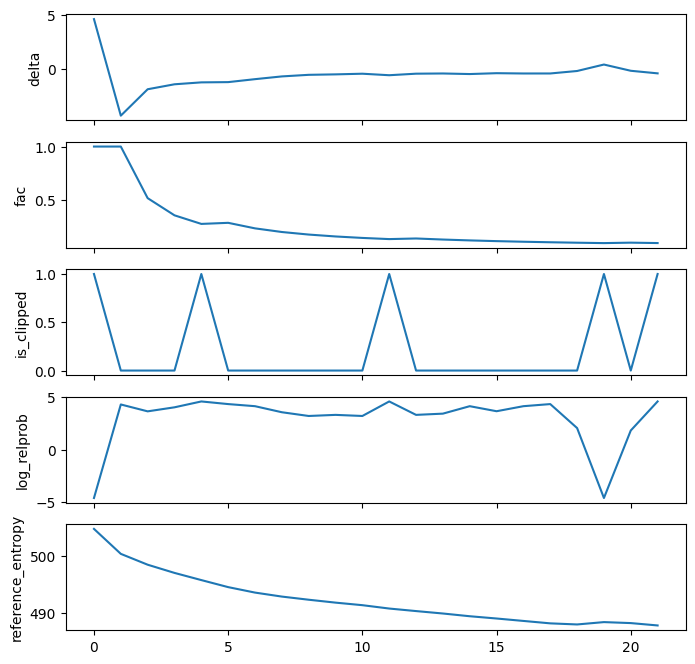

In [46]:
fig, axes = plt.subplots(5,1,figsize=(8,8),sharex=True)
for ax,k in zip(axes,[k for k in df.columns if k.startswith("re_")]):
    ax.plot(df.loc[:,k])
    ax.set_ylabel(k[3:])

In [14]:
cache = trainer._eval_data_cache
print(cache.total_weight, cache.per_class_total_weight.sum())
print(cache.per_class_total_weight)
print(sum(w.sum() if (w:=mb.get("weight")) is not None else mb["latent_program_idx"].size for mb in cache.minibatches))


AttributeError: 'NoneType' object has no attribute 'total_weight'